In [1]:
#imports for image reading
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import albumentations as alb

#imports for models
import tensorflow as tf

#extra imports
import time
import uuid
import os
import json
import traceback

In [2]:
CURRENT_PATH = os.getcwd()

IMAGE_PATH = os.path.join(os.getcwd(), 'data', 'images')
LABEL_PATH = os.path.join(os.getcwd(), 'data', 'labels')

TRAIN_PATH = os.path.join(os.getcwd(), "data", "train")
TEST_PATH = os.path.join(os.getcwd(), "data", "test")
VAL_PATH = os.path.join(os.getcwd(), "data", "val")
CURRENT_PATH

'E:\\Github\\Deep-Learning\\VideoTagger[WIP]'

##  Capturing Raw Data

In [ ]:
### capturing images through the cameras
cap = cv2.VideoCapture(0)
total_images = 10

os.chdir(IMAGE_PATH)

for i in range(total_images):
    print(f"Collecting Image number: {i}")
    ret, frame = cap.read()
    image_name = f"{str(uuid.uuid1())}.jpg"
    cv2.imwrite(image_name, frame)
    cv2.imshow("image_frame", frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## Labelling the Image 

In [ ]:
!labelme

## Spliting Data into train, test and val

In [3]:
#bringing the dataset
DATA_PATH = IMAGE_PATH+"\\*.jpg"
data = tf.data.Dataset.list_files(DATA_PATH, shuffle=True)

In [4]:
#to check if the dataset read worked - file path to an images should come as output
data.as_numpy_iterator().next()

b'E:\\Github\\Deep-Learning\\VideoTagger[WIP]\\data\\images\\8c9f0718-36c4-11ee-9678-d8bbc1768911.jpg'

In [5]:
#function to get images from the files read
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    return img

In [6]:
#map the function to the data path to get all the images

images = data.map(load_images)

# images.as_numpy_iterator().next()

In [7]:
#Visualising the images

batch_image = images.batch(batch_size=4).as_numpy_iterator()
plot_img = batch_image.next()

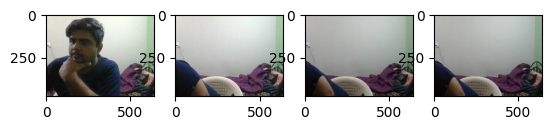

In [8]:
fig, ax = plt.subplots(ncols=4)
for index, image in enumerate(plot_img):
    ax[index].imshow(image)
plt.show()

In [12]:
28*0.2

5.6000000000000005

In [13]:
# getting the lables to the image

for i in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join(os.getcwd(), 'data', i, 'images')):
        file_name = file.split('.')[0] + ".json"
        existing_label = os.path.join(os.getcwd(), 'data', 'labels', file_name)
        if os.path.exists(existing_label):
            new_label = os.path.join(os.getcwd(), 'data', i, 'labels', file_name)
            os.replace(existing_label, new_label)

## Augment the Data

###  Creating the Augmenting pipeline

### Reading an Image

In [63]:
img = plt.imread("E:\\Github\\Deep-Learning\\VideoTagger[WIP]\\data\\train\\images\\5a2844e1-36c4-11ee-a2e4-d8bbc1768911.jpg")
# plt.imshow(img)
img.shape

(480, 640, 3)

### Reading Labels of the image

In [64]:
with open(os.path.join("E:\\Github\\Deep-Learning\\VideoTagger[WIP]\\data\\train\\", "labels", "5a2844e1-36c4-11ee-a2e4-d8bbc1768911.json"), 'r') as f:
    label = json.load(f)
label

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[164.6700507614213, 30.355329949238584],
    [380.4060913705584, 298.8832487309645]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\5a2844e1-36c4-11ee-a2e4-d8bbc1768911.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRo

### Filtering out Boundary box coordinate

In [65]:
coords = [0,0,0,0]

coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

# coords[0] = label['bboxes'][0]
# coords[1] = label['bboxes'][1]
# coords[2] = label['bboxes'][2]
# coords[3] = label['bboxes'][3]


ordinate = np.array(coords).astype(int)
# ordinate = np.multiply(ordinate, [480,0,450,450]).astype(int)
ordinate

array([164,  30, 380, 298])

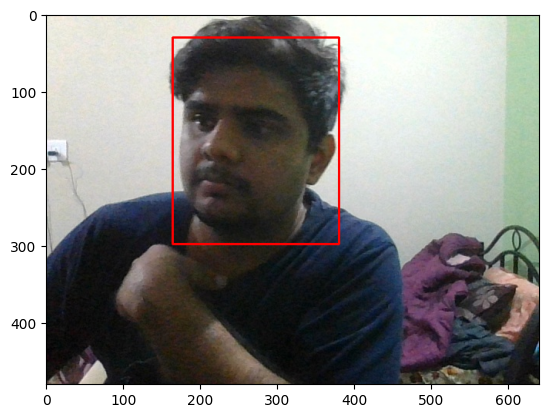

In [66]:
rect_face = cv2.rectangle(img, (ordinate[:2]), (ordinate[2:]), [255, 0, 0], 2)
plt.imshow(rect_face)

In [67]:
album_coords = list(np.divide(coords, [640, 480, 640, 480]))
album_coords

[0.25729695431472077,
 0.06324027072758039,
 0.5943845177664975,
 0.6226734348561761]

### Running the Image and Corrected Coordinates through Albumentation pipe

In [72]:
mod_img = augmentor(image=img, bboxes=[album_coords], class_labels=["face"])
# plt.imshow(mod_img[])
# mod_img['bboxes'][0][2:]

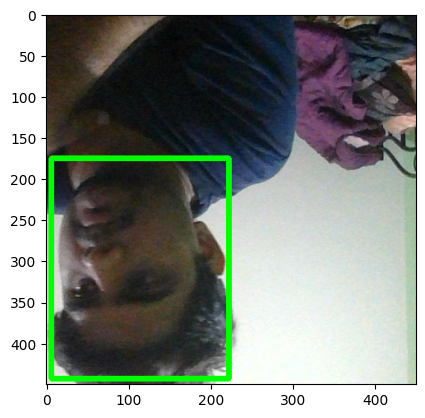

In [73]:
new_img = cv2.rectangle(mod_img['image'], (np.multiply(mod_img['bboxes'][0][:2], [450, 450]).astype(int)), 
                        (np.multiply(mod_img['bboxes'][0][2:], [450,450]).astype(int)),
                       (0,255,0), 5)

plt.imshow(new_img)
# cv2.imwrite("cv_img.jpeg", mod_img['image'])

### Fetching New Coords

In [37]:
label_img = { 'points': mod_img['bboxes'],
             'class': mod_img['class_labels']}

### Summing all Together

In [92]:
augmentor = alb.Compose(transforms=[alb.RandomCrop(width = 450, height = 450),
                                   alb.HorizontalFlip(p=0.5),
                                   alb.RandomBrightnessContrast(p=0.3),
                                   alb.RandomGamma(p=0.4),
                                   alb.RGBShift(p=0.3),
                                   alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams("albumentations", label_fields=["class_labels"]))

In [153]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('augmented', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('augmented', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [154]:
# #going through each folder
# for i in ["train", "test", "val"]:
#     #going through each image in a folder
#     for images in os.listdir(os.path.join("data", i, "images")):
#         img = cv2.imread(os.path.join("data", i, "images", images))
#         label_name = images.split('.')[0]+".json"
#         label_path = os.path.join("data", i, "labels", label_name)
        
#         #check if corresponding label json exists - and setting coordinates
#         if os.path.exists(label_path):
#             with open(os.path.join("data", i, "labels", label_name), 'r') as f:
#                 img_label = json.load(f)
#                 coords = [0,0,0,0]
#                 coords[0] = img_label['shapes'][0]['points'][0][0]
#                 coords[1] = img_label['shapes'][0]['points'][0][1]
#                 coords[2] = img_label['shapes'][0]['points'][1][0]
#                 coords[3] = img_label['shapes'][0]['points'][1][1]
#             coords = list(np.divide(coords, [640, 480, 640, 480]))
            
#         #create 60 augmented images per raw image - and save in different folder augmented for train, test and val  
#         try:
#             for j in range(60):
#                 aug_img = augmentor(image = img, bboxes = [coords], class_labels = ["face"])
#                 cv2.imwrite(os.path.join("augmented", i, "images", f"{images.split('.')[0]}_{j}.jpeg"), aug_img['image'])

#                 aug_label = {}
#                 aug_label['image'] = images
                
#                 if os.path.exists(label_path):
#                     if len(aug_img['bboxes']) == 0:
#                         aug_label['bboxes'] = [0,0,0,0]
#                         aug_label['class'] = 0
#                     else:
#                         aug_label['bboxes'] = aug_img['bboxes'][0]
#                         aug_label['class'] = 1
#                 else:
#                     aug_label['bboxes'] = [0,0,0,0]
#                     aug_label['class'] = 0
                
#                 with open(os.path.join("augmented", i, "labels", f"{images.split('.')[0]}_{j}.json"), 'w') as f:
#                     json.dump(aug_label,f)
#         except:
#             traceback.print_exc()
            

## Image Correction for Modelling

In [155]:
def get_images(file):
    img = tf.io.read_file(file)
    img = tf.io.decode_jpeg(img)

    return img

In [156]:
#train data prep

train_data = tf.data.Dataset.list_files("augmented\\train\\images\\*.jpg")
train_images = train_data.map(get_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

#test data prep
test_data = tf.data.Dataset.list_files("augmented\\test\\images\\*.jpg")
test_images = test_data.map(get_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

#val data prep
val_data = tf.data.Dataset.list_files("augmented\\val\\images\\*.jpg")
val_images = val_data.map(get_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

## Label Preparation for Modelling

In [157]:
def read_label(path):
    with open(path.numpy(), 'r',encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [158]:
train_label_data = tf.data.Dataset.list_files("augmented\\train\\labels\\*.json")
train_label = train_label_data.map(lambda x: tf.py_function(read_label, [x], [tf.uint8, tf.float16]))

test_label_data = tf.data.Dataset.list_files("augmented\\test\\labels\\*.json")
test_label = test_label_data.map(lambda x: tf.py_function(read_label, [x], [tf.uint8, tf.float16]))

val_label_data = tf.data.Dataset.list_files("augmented\\val\\labels\\*.json")
val_label = val_label_data.map(lambda x: tf.py_function(read_label, [x], [tf.uint8, tf.float16]))

## Combining Image and Labels to create Dataset

In [159]:
train = tf.data.Dataset.zip((train_images, train_label))
train = train.shuffle(4000)
train = train.batch(10)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_label))
test = test.shuffle(4000)
test = test.batch(10)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_label))
val = val.shuffle(4000)
val = val.batch(10)
val = val.prefetch(4)

In [160]:
res = train.as_numpy_iterator().next() 

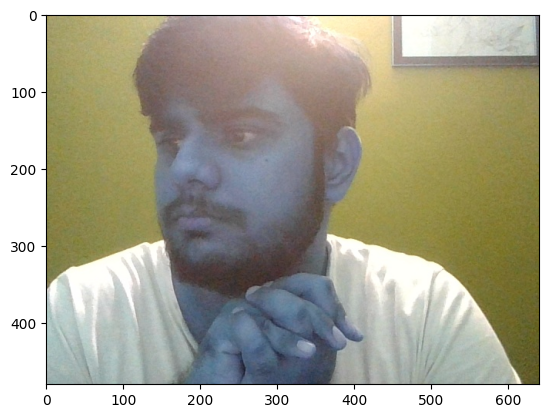

In [161]:
sam = res[0][1]
samCoord = res[1][1][1]

# coords = [0,0,0,0]
# coords[0] = samCoord[0]
# coords[1] = samCoord[1]
# coords[2] = samCoord[2]
# coords[3] = samCoord[3]


ordinate = np.array(samCoord).astype(int)
# # ordinate = np.multiply(ordinate, [480,0,450,450]).astype(int)
ordinate


rect_face = cv2.rectangle(img, (ordinate[:2]), (ordinate[2:]), [255, 0, 0], 2)
plt.imshow(rect_face)


In [162]:
samCoord

array([0.3066, 0.2223, 0.8345, 0.97  ], dtype=float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


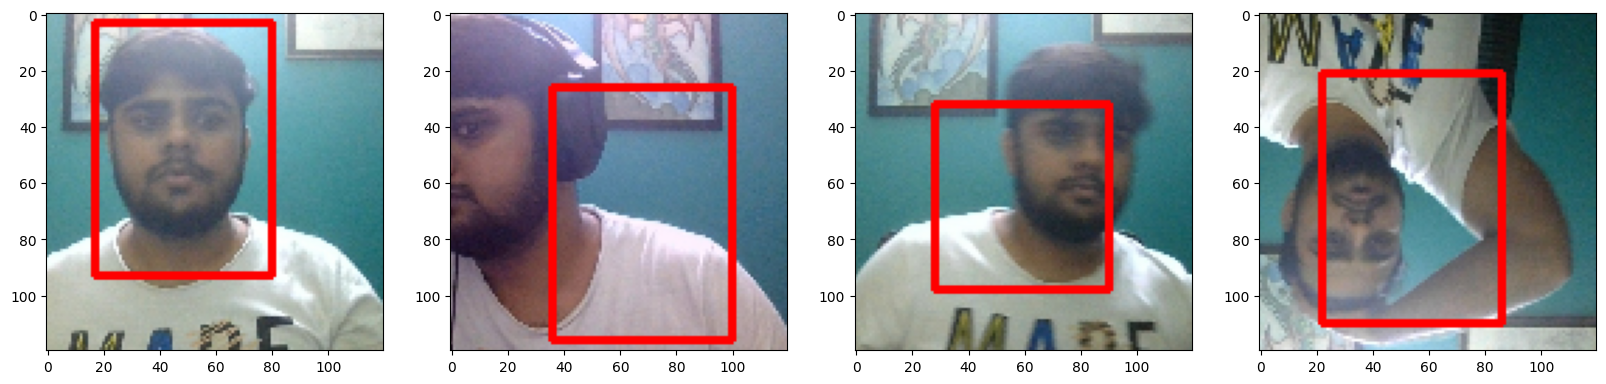

In [163]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    img = cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(img)

In [164]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [165]:
vgg = VGG16(include_top=False)

In [166]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [167]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [168]:
facetracker = build_model()

In [169]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [170]:
X, y = train.as_numpy_iterator().next()

In [171]:
X.shape

(10, 120, 120, 3)

In [172]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 342ms/step


In [173]:
classes, coords

(array([[0.44551668],
        [0.4607715 ],
        [0.5130901 ],
        [0.45592633],
        [0.45421833],
        [0.4959151 ],
        [0.5329556 ],
        [0.5726217 ],
        [0.5075871 ],
        [0.44217744]], dtype=float32),
 array([[0.7175451 , 0.5411559 , 0.508819  , 0.62064403],
        [0.73670685, 0.4895906 , 0.52822244, 0.64823925],
        [0.7824928 , 0.4990664 , 0.5343392 , 0.6988441 ],
        [0.7989203 , 0.60926545, 0.34674528, 0.7028239 ],
        [0.78573114, 0.5988194 , 0.39010194, 0.7307156 ],
        [0.7325983 , 0.55645347, 0.49393365, 0.68883324],
        [0.79381055, 0.50052434, 0.46447217, 0.6489823 ],
        [0.6588062 , 0.5271179 , 0.52437544, 0.63429576],
        [0.7763921 , 0.6041756 , 0.45279175, 0.7004252 ],
        [0.7432252 , 0.55710274, 0.4601045 , 0.6354307 ]], dtype=float32))

In [174]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [175]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [176]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [177]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [178]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.148553>

In [179]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.72379565>

In [180]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.148553>

In [181]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [182]:
model = FaceTracker(facetracker)

In [183]:
model.compile(opt, classloss, regressloss)

In [184]:
logdir='logs'

In [185]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [186]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
372/372 [==============================] - 562s 2s/step - total_loss: 1.6964 - class_loss: 0.4312 - regress_loss: 1.4808 - val_total_loss: 2.6212 - val_class_loss: 0.6867 - val_regress_loss: 2.2779
Epoch 2/10
372/372 [==============================] - 578s 2s/step - total_loss: 1.6434 - class_loss: 0.4310 - regress_loss: 1.4279 - val_total_loss: 2.8334 - val_class_loss: 0.6972 - val_regress_loss: 2.4848
Epoch 3/10
372/372 [==============================] - 595s 2s/step - total_loss: 1.6384 - class_loss: 0.4309 - regress_loss: 1.4230 - val_total_loss: 2.2077 - val_class_loss: 0.3397 - val_regress_loss: 2.0379
Epoch 4/10
372/372 [==============================] - 605s 2s/step - total_loss: 1.6323 - class_loss: 0.4297 - regress_loss: 1.4174 - val_total_loss: 2.2114 - val_class_loss: 0.5130 - val_regress_loss: 1.9549
Epoch 5/10
372/372 [==============================] - 608s 2s/step - total_loss: 1.6344 - class_loss: 0.4299 - regress_loss: 1.4194 - val_total_loss: 1.6821 - val_c

In [187]:
hist.history

{'total_loss': [2.4514408111572266,
  1.0429102182388306,
  1.9922155141830444,
  1.287320852279663,
  2.5552031993865967,
  2.2437376976013184,
  1.2864943742752075,
  1.1864688396453857,
  1.0355478525161743,
  1.8282103538513184],
 'class_loss': [0.687005341053009,
  0.15157917141914368,
  0.5020572543144226,
  0.33441853523254395,
  0.6617521047592163,
  0.6785250902175903,
  0.3320600390434265,
  0.33047884702682495,
  0.34549131989479065,
  0.5136035084724426],
 'regress_loss': [2.107938051223755,
  0.9671206474304199,
  1.7411868572235107,
  1.1201115846633911,
  2.2243270874023438,
  1.904475212097168,
  1.1204643249511719,
  1.0212293863296509,
  0.8628021478652954,
  1.5714086294174194],
 'val_total_loss': [2.621236801147461,
  2.8334176540374756,
  2.207747459411621,
  2.211381673812866,
  1.6820648908615112,
  2.469637870788574,
  2.7216598987579346,
  1.7299342155456543,
  2.804533004760742,
  1.8705272674560547],
 'val_class_loss': [0.6867145299911499,
  0.697238266468048

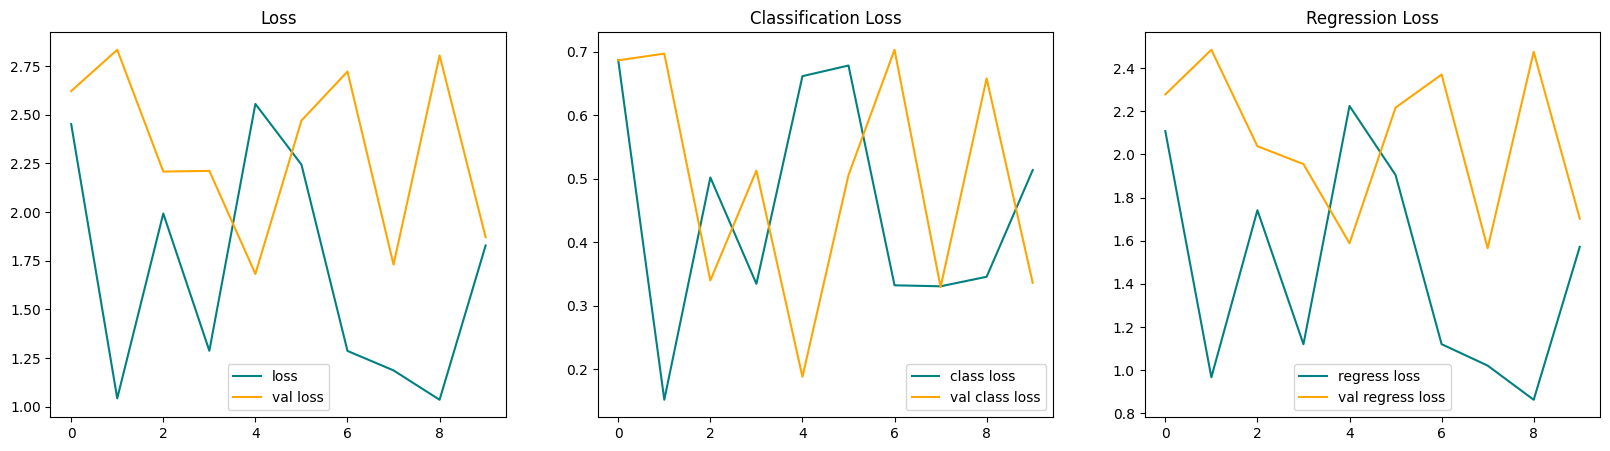

In [188]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [189]:
test_data = test.as_numpy_iterator()

In [190]:
test_sample = test_data.next()

In [206]:
yhat = facetracker.predict(test_sample[0])
yhat

1/1 [==============================] - 0s 308ms/step


[array([[0.850884  ],
        [0.85247266],
        [0.8532994 ],
        [0.85529244],
        [0.85180324],
        [0.8525979 ],
        [0.85392714],
        [0.85027957],
        [0.8544431 ],
        [0.85225743]], dtype=float32),
 array([[0.23148793, 0.18078844, 0.62176555, 0.68619734],
        [0.23146835, 0.18019207, 0.6220854 , 0.68558425],
        [0.23063636, 0.17911354, 0.62133765, 0.6856264 ],
        [0.23084486, 0.17883281, 0.62144846, 0.685066  ],
        [0.23143591, 0.180427  , 0.6221433 , 0.68593854],
        [0.23072621, 0.17920168, 0.6214371 , 0.68562007],
        [0.23132052, 0.17985511, 0.6219038 , 0.68559235],
        [0.23152402, 0.18056959, 0.6212038 , 0.68571293],
        [0.2308858 , 0.1792643 , 0.6216462 , 0.68530434],
        [0.23149545, 0.18005505, 0.62184227, 0.6856814 ]], dtype=float32)]

IndexError: index 1 is out of bounds for axis 0 with size 1

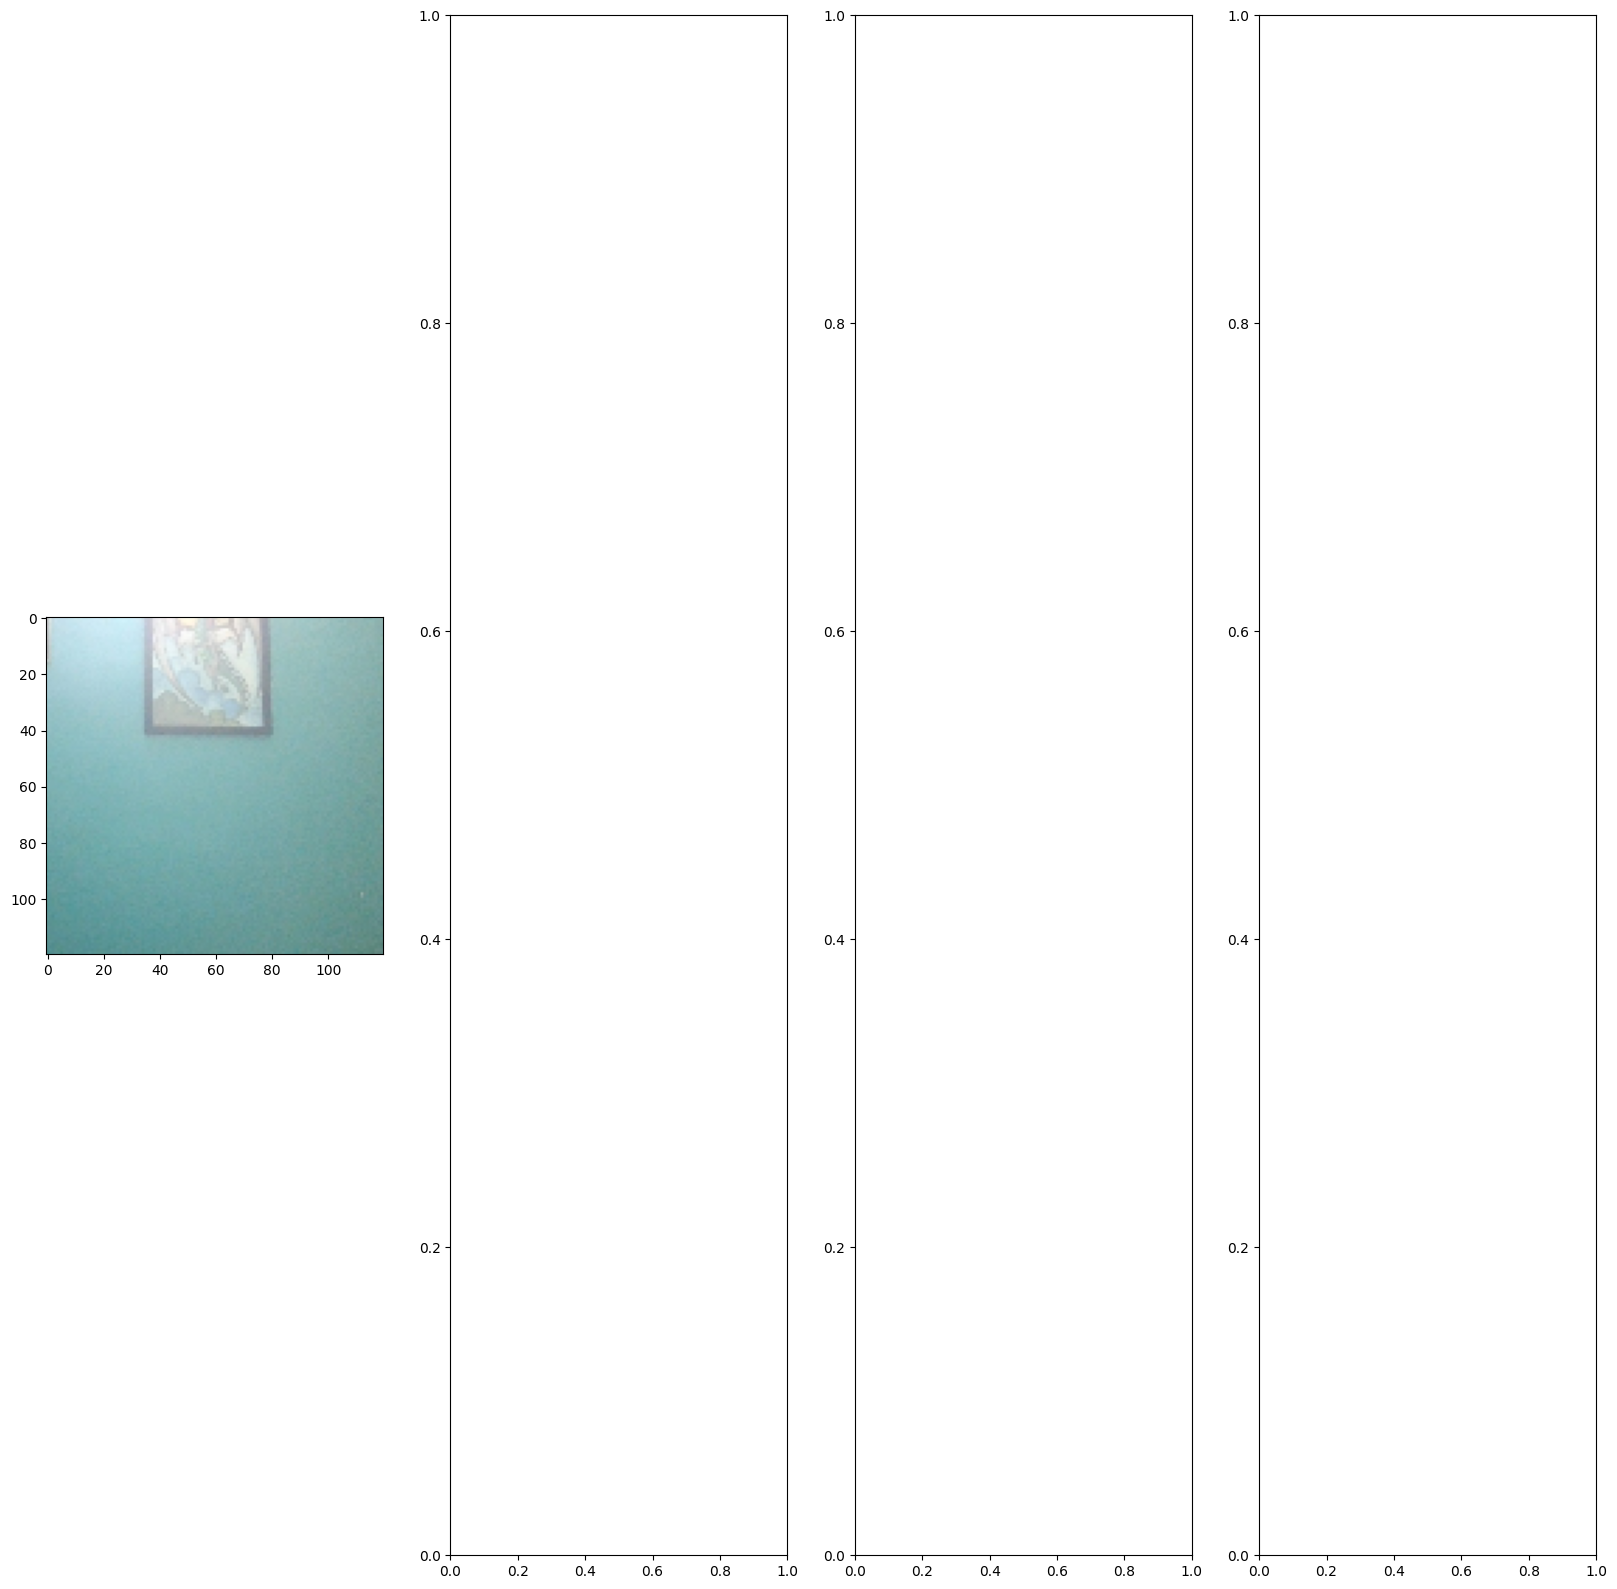

In [205]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [200]:
from tensorflow.keras.models import load_model

In [201]:
facetracker.save('facetracker.keras')

In [202]:
facetracker = load_model('facetracker.keras')

In [203]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 55ms/step
